<a href="https://colab.research.google.com/github/armiro/Covid19-Detection/blob/master/hands_on_covid_cxnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Up and running with COVID-CXNet

## Retraining/ fine-tuning CheXNet model on COVID-19 dataset

In [0]:
import glob, numpy as np, cv2, matplotlib.pyplot as plt, tensorflow as tf

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import Model, callbacks as cb, optimizers
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, Input, concatenate
from tensorflow.keras import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

from skimage.filters import rank
from skimage.morphology import disk

from BEASF import BEASF
from visualization_tools import GradCAM

number of total dataset images: 500
number of total dataset labels: 500
dataset shape: (500, 320, 320, 1)


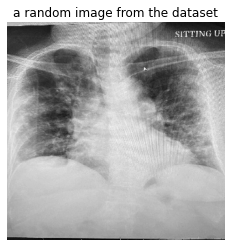

In [0]:
X = np.load(file='/content/drive/My Drive/Datasets/covid_cxr_dataset/cxr_samples.npy')
y = np.load(file='/content/drive/My Drive/Datasets/covid_cxr_dataset/cxr_labels.npy')
X = X[:500]
y = y[:500]

# X = np.concatenate((X, X, X), axis=-1)
# X = np.array([X[idx] / 255. for idx in range(len(X))])

print('number of total dataset images:', len(X))
print('number of total dataset labels:', len(y))
print('dataset shape:', X.shape)

rnd_idx = np.random.choice(a=len(X), size=None)
plt.imshow(X=X[rnd_idx].squeeze(), cmap='gray')
plt.axis('off')
plt.title(label='a random image from the dataset')
plt.show()

In [0]:
def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

segmentor = unet(input_size=(320, 320, 1))
segmentor.summary()
segmentor.load_weights('/content/drive/My Drive/cxr_reg_weights.hdf5')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 320, 320, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 320, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 160, 160, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
def do_segmentation(images, disk_rad=40, kernel_size=(5, 5), num_iter=3, margin=0):
    equ_images = [rank.equalize(image.squeeze(), selem=disk(radius=disk_rad)) for image in images]
    masks = [segmentor(np.expand_dims(equ_image, axis=[0, -1])) for equ_image in equ_images]
    masks = [cv2.dilate(np.squeeze(mask), kernel=np.ones(kernel_size), iterations=num_iter) for mask in masks]
    images = [image[np.min(np.where(masks[idx]==1)[0]) - margin:np.max(np.where(masks[idx]==1)[0]) + margin, 
                    np.min(np.where(masks[idx]==1)[1]) - margin:np.max(np.where(masks[idx]==1)[1]) + margin]
              for idx, image in enumerate(images)]
    images = [cv2.resize(image, dsize=(320, 320), interpolation=cv2.INTER_CUBIC) for image in images]
    images = [np.expand_dims(image, axis=-1) for image in images]
    return np.array(images)

In [0]:
%%time
X_segmented = do_segmentation(images=X)

num carious images: 428
num healthy images: 3200
number of total dataset images: 3628
number of total dataset labels: 3628
dataset shape: (3628, 320, 320, 3)


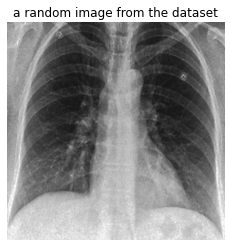

In [0]:
X = X_segmented[:3628]
y = y[:3628]

num_covid_samples = 0
num_normal_samples = 0
for idx, img in enumerate(X):
  if y[idx]:
    num_covid_samples += 1
  else:
    num_normal_samples += 1
print('num carious images:', num_covid_samples)
print('num healthy images:', num_normal_samples)


# manual label smoothing by 0.1 deviation
# y[np.where(y == 0)] = 0.1
# y[np.where(y == 1)] = 0.9

# apply image enhancements and concat with the original image
X_beasf = np.array([BEASF(image=image, gamma=1.5) for image in X])
X_clahe = np.array([cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(image) for image in X])
X_clahe = np.array([np.expand_dims(a=image, axis=-1) for image in X_clahe])
X = np.concatenate((X_beasf, X_clahe, X), axis=-1)

X = np.array([X[idx] / 255. for idx in range(len(X))])

print('number of total dataset images:', len(X))
print('number of total dataset labels:', len(y))
print('dataset shape:', X.shape)

rnd_idx = np.random.choice(a=len(X), size=None)
plt.imshow(X=X[rnd_idx].squeeze(), cmap='gray')
plt.axis('off')
plt.title(label='a random image from the dataset')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

# # NOTE: sklearn train_test_split function copies the dataset, hence deleting initial data
# # variables will increase RAM space drastically (~ x2)
del X, X_segmented, y

In [0]:
# IMPORTANT: applying zoom and brightness at the same time will change image pixel range from
# [0, 1] to [0, 255], hence we need to add rescaling again (despite doing it when importing
# dataset). Otherwise, model will see all validation data (not undergone augmentation) as 
# black images giving a same prediction value for all
augmenter = ImageDataGenerator(rotation_range=170, horizontal_flip=True, vertical_flip=True, 
                               zoom_range=[0.8, 1.5], brightness_range=[0.5, 1.3], rescale=1./255,
                               width_shift_range=0.2, height_shift_range=0.2, fill_mode='constant')

# NOTE: Keras ImageDataGenerator does not keep input image default ratio (as of v2.3.1)
# NOTE: Keras ImageDataGenerator does not resize-and-padd when doing rotation (thus 
# loosing part of the image due to cropping while rotating)
checkpoint = cb.ModelCheckpoint('/content/drive/My Drive/covid_model/eps={epoch:03d}_valLoss={val_loss:.4f}.hdf5',
                                monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cb_list = [checkpoint]

In [0]:
backbone = load_model("/content/drive/My Drive/CheXNet_model.hdf5")
fc = Dense(units=10, activation='relu', name='fc')(backbone.layers[-2].output)
do = Dropout(rate=0.2, name='dropout')(fc)
output = Dense(units=1, activation='sigmoid', name='pred')(do)
classifier = Model(inputs=backbone.input, outputs=output)
# for layer in classifier.layers[:-1]:
#     layer.trainable = False
fast_adam = optimizers.Adam(learning_rate=0.001)
smoothened_bce = tf.losses.BinaryCrossentropy(label_smoothing=0.1)
classifier.compile(optimizer=fast_adam, loss=smoothened_bce, metrics=['accuracy'])
# classifier.summary()
print('number of pretrained network layers:', len(classifier.layers))

number of pretrained network layers: 431


avg heatmap value: 4.1943727
max heatmap value: 9.359249
avg heatmap value: 6.5659437
max heatmap value: 13.47375
avg heatmap value: 3.155472
max heatmap value: 7.812208
avg heatmap value: 2.930423
max heatmap value: 8.091457
avg heatmap value: 1.485515
max heatmap value: 4.46297
avg heatmap value: 3.0465622
max heatmap value: 6.3707905


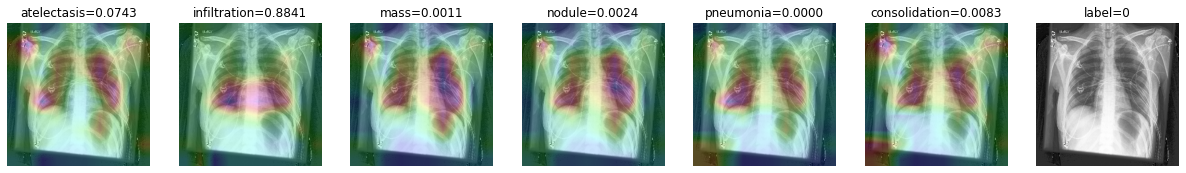

[7.4314222e-02 2.3037819e-07 2.8853895e-02 8.8414717e-01 1.1355547e-03
 2.3701508e-03 2.3021457e-05 6.4419664e-04 8.2590487e-03 8.6619275e-06
 2.4596731e-05 2.5454731e-06 2.1668599e-04 5.7640971e-12]


In [0]:
# test CheXNet accuracy and imaging features on sample cases
predictor = load_model('/content/drive/My Drive/CheXNet_model.hdf5')
IMG_ID = np.random.randint(low=0, high=len(X), size=None)
print('image index:', IMG_ID)
test_img = X[IMG_ID]
temp_img = (X[IMG_ID] * 255.).astype('uint8')

fig1 = plt.figure(num=7, figsize=(21, 3))

cam = GradCAM(model=predictor, classIdx=0, layerName=None)
heatmap = cam.compute_heatmap(image=test_img, normalize=True)
overlaid_heatmap = cam.overlay_heatmap(heatmap=heatmap, image=temp_img, alpha=0.8, 
                                       colormap=cv2.COLORMAP_HSV)
plt.subplot(1, 7, 1)
plt.imshow(overlaid_heatmap)
plt.axis('off')
plt.title('atelectasis=%.4f' % predictor.predict(np.expand_dims(test_img, axis=0))[0][0])

cam = GradCAM(model=predictor, classIdx=3, layerName=None)
heatmap = cam.compute_heatmap(image=test_img, normalize=True)
overlaid_heatmap = cam.overlay_heatmap(heatmap=heatmap, image=temp_img, alpha=0.8, 
                                       colormap=cv2.COLORMAP_HSV)
plt.subplot(1, 7, 2)
plt.imshow(overlaid_heatmap, cmap='gray')
plt.axis('off')
plt.title('infiltration=%.4f' % predictor.predict(np.expand_dims(test_img, axis=0))[0][3])

cam = GradCAM(model=predictor, classIdx=4, layerName=None)
heatmap = cam.compute_heatmap(image=test_img, normalize=True)
overlaid_heatmap = cam.overlay_heatmap(heatmap=heatmap, image=temp_img, alpha=0.8, 
                                       colormap=cv2.COLORMAP_HSV)
plt.subplot(1, 7, 3)
plt.imshow(overlaid_heatmap, cmap='gray')
plt.axis('off')
plt.title('mass=%.4f' % predictor.predict(np.expand_dims(test_img, axis=0))[0][4])

cam = GradCAM(model=predictor, classIdx=5, layerName=None)
heatmap = cam.compute_heatmap(image=test_img, normalize=True)
overlaid_heatmap = cam.overlay_heatmap(heatmap=heatmap, image=temp_img, alpha=0.8, 
                                       colormap=cv2.COLORMAP_HSV)
plt.subplot(1, 7, 4)
plt.imshow(overlaid_heatmap, cmap='gray')
plt.axis('off')
plt.title('nodule=%.4f' % predictor.predict(np.expand_dims(test_img, axis=0))[0][5])

cam = GradCAM(model=predictor, classIdx=6, layerName=None)
heatmap = cam.compute_heatmap(image=test_img, normalize=True)
overlaid_heatmap = cam.overlay_heatmap(heatmap=heatmap, image=temp_img, alpha=0.8, 
                                       colormap=cv2.COLORMAP_HSV)
plt.subplot(1, 7, 5)
plt.imshow(overlaid_heatmap, cmap='gray')
plt.axis('off')
plt.title('pneumonia=%.4f' % predictor.predict(np.expand_dims(test_img, axis=0))[0][6])

cam = GradCAM(model=predictor, classIdx=8, layerName=None)
heatmap = cam.compute_heatmap(image=test_img, normalize=True)
overlaid_heatmap = cam.overlay_heatmap(heatmap=heatmap, image=temp_img, alpha=0.8, 
                                       colormap=cv2.COLORMAP_HSV)
plt.subplot(1, 7, 6)
plt.imshow(overlaid_heatmap, cmap='gray')
plt.axis('off')
plt.title('consolidation=%.4f' % predictor.predict(np.expand_dims(test_img, axis=0))[0][8])

plt.subplot(1, 7, 7)
plt.imshow(test_img, cmap='gray')
plt.axis('off')
plt.title('label=%d' % y[IMG_ID])

plt.show()
print('all classes probabilities:')
print(predictor.predict(np.expand_dims(test_img, axis=0))[0])
# fig1.savefig(fname='/content/drive/My Drive/chexnet_ex.png')

In [0]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(y_train), y=y_train)
print('class weights are:', class_weights)
fine_tuning = classifier.fit(augmenter.flow(x=X_train, y=y_train, batch_size=16), 
                             steps_per_epoch=len(X_train)//16,
                             callbacks=cb_list, epochs=20, verbose=1, 
                             validation_data=(X_test, y_test),
                             class_weight=dict({0: class_weights[0], 1: class_weights[1]}))

fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(fine_tuning.history['loss'], color='r', label='training_loss')
plt.plot(fine_tuning.history['val_loss'], color='g', label='validation_loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(fine_tuning.history['accuracy'], color='r', label='training_accuracy')
plt.plot(fine_tuning.history['val_accuracy'], color='g', label='validation_accuracy')
plt.legend()
plt.show()
# fig.savefig('/content/drive/My Drive/covid_model/fine_tuning.png')

In [0]:
classifier.load_weights('/content/drive/My Drive/covid_model/eps=?_valLoss=?.hdf5')
y_pred = classifier.predict(X_test)
print('number of test-set images:', len(y_test))
print(y_test)
y_pred = np.round(np.reshape(a=y_pred, newshape=(1, -1)), decimals=2)[0]
print(y_pred)
y_pred_rnd = np.round(np.reshape(a=y_pred, newshape=(1, -1)))[0]
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_rnd)
print('confusion matrix:')
print(cm)
print('test-set accuracy:', (cm[0][0] + cm[1][1])/np.sum(cm))

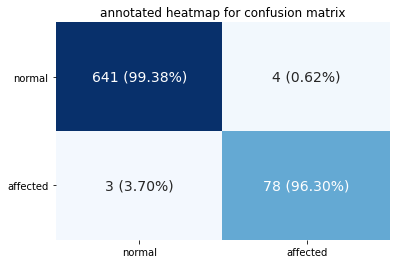

In [0]:
fig1 = plt.figure()
labels = ['normal', 'affected']
h = sns.heatmap(data=cm, cmap='Blues', annot=annotations, annot_kws={'size': 15}, fmt='d',
                vmin=0, vmax=150, xticklabels=labels, yticklabels=labels, cbar=False)
h.set_yticklabels(h.get_yticklabels(), rotation=0)
plt.title('annotated heatmap for confusion matrix')
plt.show()
# fig1.savefig('/content/drive/My Drive/cm_heatmap.png')

In [0]:
# save model config as json file
model_json = classifier.to_json()
with open("/content/drive/My Drive/COVID-CXNet_model.json", "w") as json_file:
    json_file.write(model_json)

## Heatmap generation for sample image

image index: 193
avg heatmap value: 7.593722
max heatmap value: 20.128656


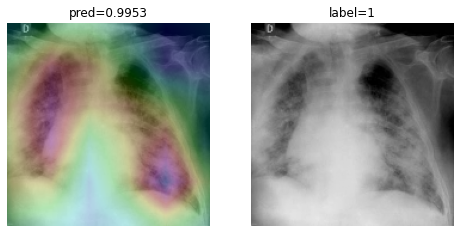

In [0]:
predictor = load_model('/content/drive/My Drive/COVID-CXNet_model.hdf5')
predictor = classifier
IMG_ID = np.random.randint(low=0, high=len(X), size=None)
# IMG_ID = ?
print('image index:', IMG_ID)

# test_img = np.zeros(shape=(600, 600, 3))
# test_img[140:460, 140:460] = X[IMG_ID]
# test_img = cv2.resize(src=test_img, dsize=(320, 320))

test_img = X[IMG_ID]
temp_img = (test_img * 255.).astype('uint8')


cam = GradCAM(model=predictor, classIdx=0, layerName=None)
heatmap = cam.compute_heatmap(image=test_img, normalize=True)
overlaid_heatmap = cam.overlay_heatmap(heatmap=heatmap, image=temp_img, alpha=0.8, 
                                       colormap=cv2.COLORMAP_HSV)

# overlaid_heatmap = overlaid_heatmap[75:245, 75:245, :]
# test_img = test_img[75:245, 75:245]

fig = plt.figure(num=2, figsize=(8, 16))
plt.subplot(2, 2, 1)
plt.imshow(overlaid_heatmap)
plt.axis('off')
plt.title('pred=%.4f' % predictor.predict(np.expand_dims(test_img, axis=0)))

plt.subplot(2, 2, 2)
plt.imshow(test_img, cmap='gray')
plt.axis('off')
plt.title('label=%d' % y[IMG_ID])
plt.show()
# fig.savefig('/content/drive/My Drive/f_%d.jpg' % IMG_ID, bbox_inches='tight', pad_inches=0.1)